<a href="https://colab.research.google.com/github/tieliuzhou/Deep-Learning-Final-Proj/blob/main/Final_Ver_of_DL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedestrian Re-identification Project

In [ ]:
!sudo lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


# Preparation

## Environment Setup

In [ ]:
!pip install pretrainedmodels
import time
import os
import random
import math
from shutil import copyfile
from typing import Tuple
import matplotlib.pyplot as plt
from PIL import Image

import torch 
from torch import nn, Tensor
from torch.nn import init
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pretrainedmodels
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

import torch.backends.cudnn as cudnn

from importlib import import_module
from __future__ import absolute_import

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=dccbee084b105fd145e5c578dfdd17e7d61ca6122b6f8e6304b8367e687055a3
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [ ]:
class RandomErasing(object):
    """ Randomly selects a rectangle region in an image and erases its pixels.
        'Random Erasing Data Augmentation' by Zhong et al.
        See https://arxiv.org/pdf/1708.04896.pdf
    Args:
         probability: The probability that the Random Erasing operation will be performed.
         sl: Minimum proportion of erased area against input image.
         sh: Maximum proportion of erased area against input image.
         r1: Minimum aspect ratio of erased area.
         mean: Erasing value. 
    """
    
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                return img

        return img


### Check

In [ ]:
print(f"\n cuda is available:　{torch.cuda.is_available()}",
      f"\n device count     :  {torch.cuda.device_count()}",
      f"\n device name      :  {torch.cuda.get_device_name(0)}",)


 cuda is available:　True 
 device count     :  1 
 device name      :  Tesla P100-PCIE-16GB


In [ ]:
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True
if device.type != 'cuda':
    raise Exception("Please change runtime type to GPU")

In [ ]:
!rm -rf /usr/local/cuda
!ln -s /usr/local/cuda-10.1 /usr/local/cuda

In [ ]:
!nvcc --version
print (torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
1.8.1+cu101


## Dataset Download

For Market-1501, the image name contains the identity label and camera id

```
├── Market/  
│   ├── bounding_box_test/      /* Files for   testing (candidate images pool)   
│   ├── bounding_box_train/     /* Files for   training   
│   ├── gt_bbox/                /* Files for   multiple query testing   
│   ├── gt_query/               /* We do not use it   
│   ├── query/                  /* Files for   testing (query images)  
│   ├── readme.txt  
```

In [ ]:
!gdown https://drive.google.com/uc?id=1dvELil1G_wa5htdw-QOLunRUwpoZgfG0
!unzip -q Market-1501-v15.09.15.zip 
!mv Market-1501-v15.09.15 Market

Downloading...
From: https://drive.google.com/uc?id=1dvELil1G_wa5htdw-QOLunRUwpoZgfG0
To: /content/Market-1501-v15.09.15.zip
153MB [00:02, 70.4MB/s]


In [ ]:
def CopyFile(Path, Save_Path):
  for root, dirs, files in os.walk(Path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')
        src_path = Path + '/' + name
        dst_path = Save_Path + '/' + ID[0] 
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

In [ ]:
def Prepare_Data(Path, Save_Path):
  if not os.path.isdir(Save_Path):
    os.mkdir(Save_Path)

  CopyFile(Path, Save_Path)

In [ ]:
# Define your dataset download path
download_path = '/content/Market'

if not os.path.isdir(download_path):
    print('please change the download_path')

save_path = download_path + '/pytorch'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [ ]:
#query
query_path = download_path + '/query'
query_save_path = download_path + '/pytorch/query'
Prepare_Data(query_path, query_save_path)

#multi-query
query_path = download_path + '/gt_bbox'
# for dukemtmc-reid, we do not need multi-query
if os.path.isdir(query_path):
    query_save_path = download_path + '/pytorch/multi-query'
    Prepare_Data(query_path, query_save_path)

#gallery
gallery_path = download_path + '/bounding_box_test'
gallery_save_path = download_path + '/pytorch/gallery'
Prepare_Data(gallery_path, gallery_save_path)

#train_all
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train_all'
Prepare_Data(train_path, train_save_path)

In [ ]:
#train_val
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train'
val_save_path = download_path + '/pytorch/val'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
    os.mkdir(val_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            # first image is used as val image
            dst_path = val_save_path + '/' + ID[0]  
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

# Build Neural Network

We can use the pretrained networks, such as AlexNet, VGG16, ResNet and DenseNet.  
Generally, the pretrained networks help to achieve a better performance,  
since it preserves some good visual patterns from ImageNet

In pytorch, we can easily import them. For example,

In [ ]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

But we need to modify the networks a little bit.  
There are 751 classes (different people) in Market-1501,  
which is different with 1,000 classes in ResNet.fc.  
So here we need to define a new fc layer.

## 1. Define the weight initialization function.

In [ ]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        # Choosing fan_in preserves the magnitude of the variance
        # of the weights in the forward pass. 
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        # Choosing fan_out preserves the magnitudes 
        # in the backwards pass.
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

## 2. Defines new classifier layer

|--Linear--|--bn--|--relu--|--Linear--|  
Use Batch Normalization to avoid "Internal Covariate Shift",  
which keep the input of each layer of the neural network equally distributed  
and avoid gradient disappearance.

In [ ]:
class ClassTransferLayer(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True):
        super(ClassTransferLayer, self).__init__()
        layers = []
        if linear:
            layers += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            layers += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            layers += [nn.LeakyReLU(0.1)]
        if droprate > 0:
            layers += [nn.Dropout(p=droprate)]
        # add layers to the network
        layers = nn.Sequential(*layers)
        # weight initialization
        layers.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.layers = layers
        self.classifier = classifier
    def forward(self, x):
        x = self.layers(x)
        x = self.classifier(x)
        return x

## Define the ResNet50-based Model

In [ ]:
class ft_net(nn.Module):
    def __init__(self, class_num, droprate=0.5, stride=2):
        super(ft_net, self).__init__()
        # load the pretrained model
        model_ft = models.resnet50(pretrained=True)
        # change avg pooling to global pooling
        if stride == 1:
            model_ft.layer4[0].downsample[0].stride = (1,1)
            model_ft.layer4[0].conv2.stride = (1,1)
        # change avg pooling to global pooling
        model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.model = model_ft
        self.classifier = ClassTransferLayer(2048, class_num, droprate=droprate)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x


# Data Preparation

## Data Transformer

In [ ]:
transform_train_list = [
        # Resize and use interpolation
        transforms.Resize((256,128), interpolation=torchvision.transforms.functional.InterpolationMode.BICUBIC),
        # Fill the image pixels, e.g. 20*20->40*40
        transforms.Pad(10),
        # Random center cut images
        transforms.RandomCrop((256,128)),
        # Random image flip horizontally, left-right alignment
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Data normalization, 
        # these values are sampled from the imagenet training set
        # input[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

transform_val_list = [
        transforms.Resize(size=(256,128), interpolation=transforms.functional.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

In [ ]:
erasing_p = 0
color_jitter = False

if erasing_p > 0:
    transform_train_list = transform_train_list + \
    [RandomErasing(probability = erasing_p, mean=[0.0, 0.0, 0.0])]

if color_jitter:
    transform_train_list = [transforms.ColorJitter(
        brightness=0.1, contrast=0.1, saturation=0.1, hue=0)] \
        + transform_train_list

print(transform_train_list)
# Stringing together multiple image transformation operations
data_transforms = {
    'train': transforms.Compose(transform_train_list),
    'val': transforms.Compose(transform_val_list),
}

[Resize(size=(256, 128), interpolation=bicubic), Pad(padding=10, fill=0, padding_mode=constant), RandomCrop(size=(256, 128), padding=None), RandomHorizontalFlip(p=0.5), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]


## Load Data

In [ ]:
train_all = ''

# load data
data_dir = '/content/Market/pytorch'

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(
    os.path.join(data_dir, 'train' + train_all), data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(
    os.path.join(data_dir, 'val'), data_transforms['val'])

In [ ]:
batchsize=32
# more workers may work faster
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=batchsize, 
    shuffle=True, num_workers=2, pin_memory=True) 
    for x in ['train', 'val']
}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
train_class_names = image_datasets['train'].classes

In [ ]:
since = time.time()
inputs, classes = next(iter(dataloaders['train']))
print(time.time()-since)

5.884365797042847


In [ ]:
print (dataset_sizes)

{'train': 12185, 'val': 751}


# Train the Model

### Params Defined

In [ ]:
# loss history
y_loss = {'train':[], 'val':[]} 
y_err = {'train':[], 'val':[]}

Params = {
    "train_class_num" : len(train_class_names),
    "droprate" : 0.5,
    "stride" : 2,
    "lr" : 0.05,
    "batchsize" : 32,
    "warm_epoch" : 5,
    "epochs" : 60,
}
Loss = nn.CrossEntropyLoss()

### Function Defined

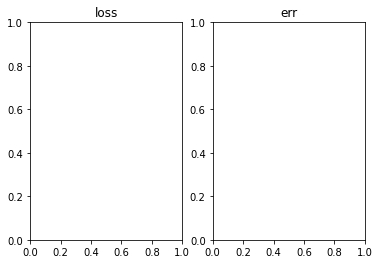

In [ ]:
# Draw Curve
name = "ft_ResNet50"
Path1 = "/content/model"
if not os.path.isdir(Path1):
    os.mkdir(Path1)
Path2 = os.path.join('/content/model',name)
if not os.path.isdir(Path2):
    os.mkdir(Path2)
x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="err")
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig( os.path.join('/content/model',name,'train.png'))

# Save model
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth'% epoch_label
    save_path = os.path.join('/content/model',name,save_filename)
    torch.save(network.cpu().state_dict(), save_path)
    if torch.cuda.is_available():
        network.cuda()

In [ ]:
def check_best_model():
    if len(y_loss['train']) == 0 or len(y_loss['val']) == 0:
        return True
    elif y_loss['train'][-1] == min(y_loss['train']) and y_loss['val'][-1] == min(y_loss['val']):
        return True

    return False

In [ ]:
def train(model, Loss, optimizer, scheduler, Params):
    begin = time.time()

    # start from the 0.1*lrRate
    warm_up = 0.1 
    warm_iteration = round(dataset_sizes['train']/Params['batchsize'])*Params['warm_epoch']
    best_epoch = 0
    epochs = Params.get("epochs", 25)

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for class_ in ['train', 'val']:
            if class_ == 'train':
                # Set model to training mode
                model.train(True)
            else:
                # Set model to evaluate mode
                model.train(False)

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloaders[class_]:
                  inputs, labels = data
                  batch_size, c, h, w = inputs.shape
                  # skip the last batch
                  if batch_size < Params['batchsize']:
                      continue
                  
                  inputs = Variable(inputs.cuda().detach())
                  labels = Variable(labels.cuda().detach())

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  if class_ == 'val':
                      with torch.no_grad():
                          outputs = model(inputs)
                  else:
                      outputs = model(inputs)

                  loss = Loss(outputs, labels)
                  _, pred_y = torch.max(outputs.data, 1)

                  # backward + optimize only if in training
                  if epoch < Params['warm_epoch'] and class_ == 'train':
                      warm_up = min(1.0, warm_up + 0.9 / warm_iteration)
                      loss *= warm_up

                  if class_ == 'train':
                      loss.backward()
                      # use optimier to backward loss
                      optimizer.step()

                  # statistics
                  running_loss += loss.item() * batch_size
                  running_corrects += float(torch.sum(pred_y == labels.data))

            if class_ == 'train':   
                scheduler.step()
            # Total loss and accuracy
            epoch_loss = running_loss / dataset_sizes[class_]
            epoch_acc = running_corrects / dataset_sizes[class_]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                class_, epoch_loss, epoch_acc))
            
            y_loss[class_].append(epoch_loss)
            y_err[class_].append(1.0 - epoch_acc)            
            # deep copy the model
            if class_ == 'val':
                # save the best model
                if check_best_model():
                    best_epoch = epoch + 1
                    best_model_wts = model.state_dict()
                if epoch%10 == 9:
                    save_network(model, epoch)
                draw_curve(epoch)

        time_elapsed = time.time() - begin
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print()

    time_elapsed = time.time() - begin
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    print("The best epoch is {}".format(best_epoch))
    for c in ['train', 'val']:
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    c, y_loss[c][best_epoch-1], 1 - y_err[c][best_epoch-1]))
    model.load_state_dict(best_model_wts)
    save_network(model, 'best')
    return model

### Train

In [ ]:
model = ft_net(Params['train_class_num'])

ignored_params = list(map(id, model.classifier.parameters() ))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())

# Use SGD Optimizer
# optimizer object can save the current parameter state 
# and update the parameters based on the calculated gradient
# parameters: params (iterable) used for optimization can iterate over parameters 
# or define parameter sets, lr learning rate, momentum momentum factor.
# weight_decay weight decay, dampening momentum suppression factor (default: 0), 
# use Nesterov momentum (default: False)
optimizer_ft = optim.SGD([
    {'params': base_params, 'lr': 0.1*Params['lr']},
    {'params': model.classifier.parameters(), 'lr': Params['lr']}
], weight_decay=5e-4, momentum=0.9, nesterov=True)

# Decay LR by a factor of 0.1 every 40 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# model to gpu
model = model.cuda()
model  = train(model, Loss, optimizer_ft, exp_lr_scheduler, Params)

Epoch 1/60
----------
train Loss: 0.8375 Acc: 0.1979
val Loss: 3.2261 Acc: 0.3542
Training complete in 1m 15s

Epoch 2/60
----------
train Loss: 0.5587 Acc: 0.6672
val Loss: 1.2930 Acc: 0.6951
Training complete in 2m 33s

Epoch 3/60
----------
train Loss: 0.4003 Acc: 0.8247
val Loss: 1.0219 Acc: 0.7457
Training complete in 3m 52s

Epoch 4/60
----------
train Loss: 0.4476 Acc: 0.8412
val Loss: 1.1127 Acc: 0.7084
Training complete in 5m 11s

Epoch 5/60
----------
train Loss: 0.6749 Acc: 0.8033
val Loss: 1.1902 Acc: 0.7084
Training complete in 6m 30s

Epoch 6/60
----------
train Loss: 0.6659 Acc: 0.8222
val Loss: 0.7183 Acc: 0.8123
Training complete in 7m 49s

Epoch 7/60
----------
train Loss: 0.3503 Acc: 0.9021
val Loss: 0.6248 Acc: 0.8229
Training complete in 9m 8s

Epoch 8/60
----------
train Loss: 0.1779 Acc: 0.9550
val Loss: 0.4914 Acc: 0.8642
Training complete in 10m 27s

Epoch 9/60
----------
train Loss: 0.1214 Acc: 0.9736
val Loss: 0.3935 Acc: 0.9055
Training complete in 11m 46s



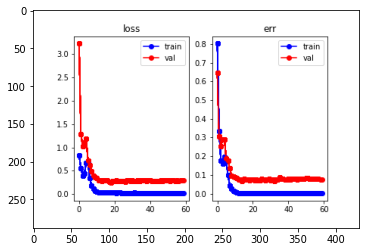

In [ ]:
im = im=Image.open('/content/model/ft_ResNet50/train.png')
plt.imshow(im)

## Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp /content/model/ft_ResNet50/net_best.pth /content/drive/MyDrive/DL/Model/

# Extract feature

import the model structure and then load the weight to the model.  
For every query and gallery image, extract the feature by simply forward the data.

In [ ]:
data_transforms['eval'] = transforms.Compose([
        transforms.Resize((256,128), interpolation=transforms.functional.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
image_datasets_eval = {
    x: datasets.ImageFolder( os.path.join(data_dir,x) ,
                            data_transforms['eval']) 
    for x in ['gallery','query','multi-query']
    }
image_datasets = {**image_datasets, **image_datasets_eval}

dataloaders_eval= {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=Params['batchsize'],
        shuffle=False, num_workers=4) 
    for x in ['gallery','query','multi-query']
    }
dataloaders = {**dataloaders, **dataloaders_eval}

In [ ]:
class_names = image_datasets['query'].classes

In [ ]:
def fliplr(img):
    '''flip horizontal'''
    inv_idx = torch.arange(img.size(3)-1,-1,-1).long()  # N x C x H x W
    img_flip = img.index_select(3,inv_idx)
    return img_flip

def extract_feature(model,dataloaders):
    features = torch.FloatTensor()
    for data in dataloaders:
        img, label = data
        n, c, h, w = img.size()
        ff = torch.FloatTensor(n,512).zero_().cuda()

        for i in range(2):
            if(i==1):
                img = fliplr(img)
            input_img = Variable(img.cuda())
            outputs = model(input_img) 
            ff += outputs
        # norm feature
        # p=2 -> l2-norm
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))

        features = torch.cat((features,ff.data.cpu()), 0)
    return features

def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        #filename = path.split('/')[-1]
        filename = os.path.basename(path)
        label = filename[0:4]
        camera = filename.split('c')[1]
        if label[0:2]=='-1':
            labels.append(-1)
        else:
            labels.append(int(label))
        camera_id.append(int(camera[0]))
    return camera_id, labels

In [ ]:
gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)

mquery_path = image_datasets['multi-query'].imgs
mquery_cam,mquery_label = get_id(mquery_path)

## Load Model

Download the best model we saved before.

In [ ]:
!gdown https://drive.google.com/uc?id=1akjH8rtvW_gjloTvVIBPBI93kZVa5bDQ

Downloading...
From: https://drive.google.com/uc?id=1akjH8rtvW_gjloTvVIBPBI93kZVa5bDQ
To: /content/net_best.pth
108MB [00:00, 176MB/s] 


In [ ]:
test_model = ft_net(751, stride=2)
test_model.load_state_dict(torch.load('/content/net_best.pth'))  
test_model.classifier.classifier = nn.Sequential()
test_model = test_model.eval()
test_model = test_model.cuda()

In [ ]:
with torch.no_grad():
    gallery_feature = extract_feature(test_model,dataloaders['gallery'])
    query_feature = extract_feature(test_model,dataloaders['query'])
    mquery_feature = extract_feature(test_model,dataloaders['multi-query'])

In [ ]:
result = {
    'gallery_f':gallery_feature.numpy(),
    'gallery_label':np.array(gallery_label),
    'gallery_cam':np.array(gallery_cam),
    'query_f':query_feature.numpy(),
    'query_label':np.array(query_label),
    'query_cam':np.array(query_cam),
    'mquery_f':mquery_feature.numpy(),
    'mquery_label':np.array(mquery_label),
    'mquery_cam':np.array(mquery_cam)
    }

# Evaluation

In [ ]:
def evaluate(qf,ql,qc,gf,gl,gc):
    # calculating cosine distance with normalized vectors
    query = qf.view(-1,1)
    score = torch.mm(gf,query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    # predict index
    index = np.argsort(score)  #from small to large
    index = index[::-1]
    # good index
    query_index = np.argwhere(gl==ql)
    camera_index = np.argwhere(gc==qc)

    good_index = np.setdiff1d(query_index, camera_index, assume_unique=True)
    junk_index1 = np.argwhere(gl==-1)
    junk_index2 = np.intersect1d(query_index, camera_index)
    junk_index = np.append(junk_index2, junk_index1) #.flatten())
    
    CMC_tmp = compute_mAP(index, good_index, junk_index)
    return CMC_tmp


def compute_mAP(index, good_index, junk_index):
    ap = 0
    cmc = torch.IntTensor(len(index)).zero_()
    if good_index.size==0:   # if empty
        cmc[0] = -1
        return ap,cmc

    # remove junk_index
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]

    # find good_index index
    ngood = len(good_index)
    mask = np.in1d(index, good_index)
    rows_good = np.argwhere(mask==True)
    rows_good = rows_good.flatten()
    
    cmc[rows_good[0]:] = 1
    for i in range(ngood):
        d_recall = 1.0/ngood
        precision = (i+1)*1.0/(rows_good[i]+1)
        if rows_good[i]!=0:
            old_precision = i*1.0/rows_good[i]
        else:
            old_precision=1.0
        ap = ap + d_recall*(old_precision + precision)/2

    return ap, cmc

In [ ]:
gallery_label = np.array(gallery_label)
gallery_cam = np.array(gallery_cam)
query_label = np.array(query_label)
query_cam = np.array(query_cam)
mquery_label = np.array(mquery_label)
mquery_cam = np.array(mquery_cam)

In [ ]:
query_feature = query_feature.cuda()
gallery_feature = gallery_feature.cuda()
mquery_feature = mquery_feature.cuda()

## Single-query

In [ ]:
CMC = torch.IntTensor(len(gallery_label)).zero_()
ap = 0.0

In [ ]:
for i in range(len(query_label)):
    ap_tmp, CMC_tmp = evaluate(query_feature[i],query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)
    if CMC_tmp[0]==-1:
        continue
    CMC = CMC + CMC_tmp
    ap += ap_tmp

In [ ]:
CMC = CMC.float()
CMC = CMC/len(query_label) #average CMC
print('Rank@1:%f Rank@5:%f Rank@10:%f mAP:%f'%(CMC[0],CMC[4],CMC[9],ap/len(query_label)))
print(CMC[:10])

Rank@1:0.886580 Rank@5:0.951010 Rank@10:0.967933 mAP:0.711723
tensor([0.8866, 0.9210, 0.9335, 0.9436, 0.9510, 0.9558, 0.9602, 0.9620, 0.9650,
        0.9679])


In [ ]:
x = [i+1 for i in range(len(CMC))]

Text(0.5, 1.0, 'Single-Query CMC Curve')

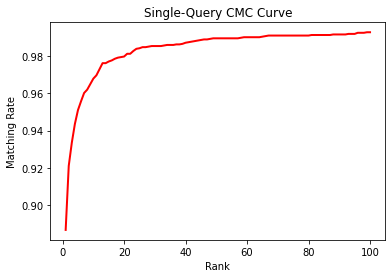

In [ ]:
plt.figure()
plt.plot(x[0:100],CMC[0:100],color="red",linewidth=2)
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("Single-Query CMC Curve")

## Multiple-query


Use multiple images of the same person as input for higher accuracy and robustness.  
In practice, a common practice is to average the features proposed by each image.

In [ ]:
CMC_multi = torch.IntTensor(len(gallery_label)).zero_()
ap = 0.0
for i in range(len(query_label)):
    mquery_index1 = np.argwhere(mquery_label==query_label[i])
    mquery_index2 = np.argwhere(mquery_cam==query_cam[i])
    mquery_index =  np.intersect1d(mquery_index1, mquery_index2)
    mq = torch.mean(mquery_feature[mquery_index,:], dim=0)
    ap_tmp, CMC_tmp = evaluate(mq,query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)
    if CMC_tmp[0]==-1:
        continue
    CMC_multi = CMC_multi + CMC_tmp
    ap += ap_tmp
CMC_multi = CMC_multi.float()
CMC_multi = CMC_multi/len(query_label) #average CMC
print('multi Rank@1:%f Rank@5:%f Rank@10:%f mAP:%f'%(CMC_multi[0],CMC_multi[4],CMC_multi[9],ap/len(query_label)))
print(CMC_multi[:10])

multi Rank@1:0.927257 Rank@5:0.951010 Rank@10:0.967933 mAP:0.797816
tensor([0.9273, 0.9522, 0.9629, 0.9700, 0.9736, 0.9762, 0.9789, 0.9804, 0.9807,
        0.9828])


Text(0.5, 1.0, 'Multiple-Query CMC Curve')

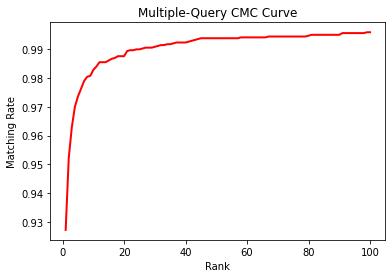

In [ ]:
plt.plot(x[0:100],CMC_multi[0:100],color="red",linewidth=2)
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("Multiple-Query CMC Curve")

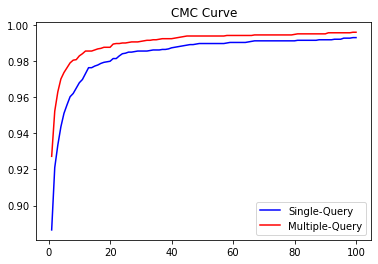

In [ ]:
Fig = plt.figure()
ax0 = Fig.add_subplot(111, title="CMC Curve")

x = np.arange(1,CMC.shape[0]+1)  
ax0.plot(x[0:100], CMC[0:100], 'b', label='Single-Query')
ax0.plot(x[0:100], CMC_multi[0:100], 'r', label='Multiple-Query')
ax0.legend()

# Demo

In [ ]:
#Show result
def imshow(path, title=None):
    """Imshow for Tensor."""
    im = plt.imread(path)
    plt.imshow(im)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# sort the images
def sort_img(qf, ql, qc, gf, gl, gc):
    query = qf.view(-1,1)
    # print(query.shape)
    score = torch.mm(gf,query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    # predict index
    index = np.argsort(score)  #from small to large
    index = index[::-1]
    # index = index[0:2000]
    # good index
    query_index = np.argwhere(gl==ql)
    #same camera
    camera_index = np.argwhere(gc==qc)

    #good_index = np.setdiff1d(query_index, camera_index, assume_unique=True)
    junk_index1 = np.argwhere(gl==-1)
    junk_index2 = np.intersect1d(query_index, camera_index)
    junk_index = np.append(junk_index2, junk_index1) 

    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]
    return index

In [ ]:
i = 333
index_demo = sort_img(query_feature[i],query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)

/content/Market/pytorch/query/0153/0153_c1s1_025901_00.jpg
Top 10 images are as follow:
/content/Market/pytorch/gallery/0092/0092_c1s1_014776_01.jpg
/content/Market/pytorch/gallery/0092/0092_c5s1_014501_02.jpg
/content/Market/pytorch/gallery/0092/0092_c1s1_014601_02.jpg
/content/Market/pytorch/gallery/0092/0092_c5s1_014501_07.jpg
/content/Market/pytorch/gallery/0092/0092_c3s1_013776_01.jpg
/content/Market/pytorch/gallery/0092/0092_c5s1_014376_01.jpg
/content/Market/pytorch/gallery/0137/0137_c4s1_022076_01.jpg
/content/Market/pytorch/gallery/0092/0092_c1s1_014776_04.jpg
/content/Market/pytorch/gallery/0092/0092_c5s1_014376_03.jpg
/content/Market/pytorch/gallery/0092/0092_c5s1_017051_02.jpg


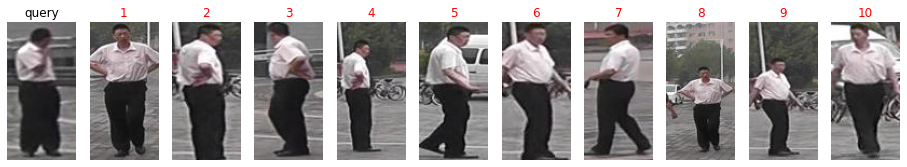

In [ ]:
query_demo_path, _ = image_datasets['query'].imgs[i]
query_demo_label = query_label[i]
print(query_demo_path)
print('Top 10 images are as follow:')
try: # Visualize Ranking Result 
    # Graphical User Interface is needed
    fig = plt.figure(figsize=(16,4))
    ax = plt.subplot(1,11,1)
    ax.axis('off')
    imshow(query_demo_path,'query')
    for i in range(10):
        ax = plt.subplot(1,11,i+2)
        ax.axis('off')
        img_path, _ = image_datasets['gallery'].imgs[index_demo[i]]
        label = gallery_label[index_demo[i]]
        imshow(img_path)
        if label == query_demo_label:
            ax.set_title('%d'%(i+1), color='green')
        else:
            ax.set_title('%d'%(i+1), color='red')
        print(img_path)
except RuntimeError:
    for i in range(10):
        img_path = image_datasets.imgs[index_demo[i]]
        print(img_path[0])
    print('If you want to see the visualization of the ranking result, graphical user interface is needed.')

fig.savefig("show.png")